
## TKO_3120 Machine Learning and Pattern Recognition

### exercise project 
Aleksandr Krylov

**student number**: 612249

**email**: alkryl@utu.fi

date 30/04/2019

# Image recognition

## Introduction

The task is devoted to image recognition of colored images. As an input, we have a row data (four sets of images of honeycombs, bird nests, lighthouses and monarch butterflies). In other words, we have a bunch of pictures representing four different classes with one object within a picture to be recognized, i.e. assign a picture to one of a given set of classes (honeycomb, bird nest, lighthouse or monarch butterfly).

We are going to train three different classifiers such as kNN, regularized linear model and multi-layer perceptron and estimate the accuracy of each of these ones. 

Before passing the original data into any classifier, preprocessing and feature extraction are required. While doing preprocessing, PCA and SOM will be used to make an illustration of the original data in a feature space, a reduced one.  

Finally, we'll interpret gained results, discuss the pros and cons of each model, and suggest some ways to improve built estimators performance.

In [1]:
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.transform import rescale, resize
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='svg'

In [4]:
sns.set()

In [5]:
# Load the data from text files 
honeycombs_urls = np.loadtxt(r"data/honeycombs.txt", dtype='U100')
birdnests_urls = np.loadtxt(r"data/birdnests.txt", dtype='U100')
lighthouses_urls = np.loadtxt(r"data/lighthouses.txt", dtype='U100')
monarchbutterflies_urls = np.loadtxt(r"data/monarchbutterflies.txt", dtype='U100')

In [6]:
def create_image_array(file_with_img_urls):
    """
    Create a numpy array of shape (n_instances, n_vpixels, n_hpixels, 3) containing images
    retrieved from an input text file with URLs
    """
    img_array = list()
    for img_url in file_with_img_urls:
        img = imread(img_url) # read the URL of image and store an image as 3-dimensional numpy array
        img_array.append(img)
        
    return np.array(img_array)

In [7]:
# Create arrays for each class of images represented as 3D numpy arrays 
honeycombs = create_image_array(honeycombs_urls)
birdnests = create_image_array(birdnests_urls)
lighthouses = create_image_array(lighthouses_urls)
monarchbutterflies = create_image_array(monarchbutterflies_urls)

## Data set

We use images from image database <a href='http://www.image-net.org/'>ImageNet</a> which provides URLs for quality-controlled and human annotated images.

In addition to three image sets provided as the default, we use one more extra data set of our own choice. A butterfly was chosen as an additional object to recognize.

A below figure illustrate the class distribution. Based on it, we assume that all the classes are more or less uniformly represented in the whole data set, and thus have an equal chance to be recognized so that no class dominates over another ones while making predictions. 

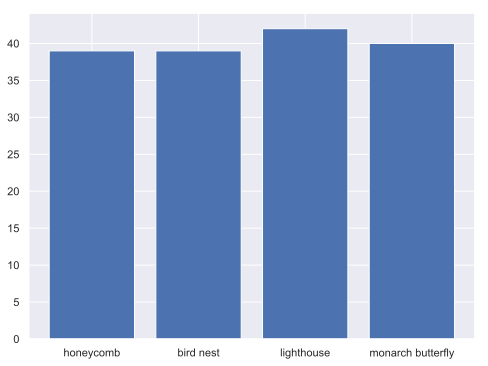

In [8]:
shapes = np.array([honeycombs.shape[0], birdnests.shape[0], lighthouses.shape[0], monarchbutterflies.shape[0]])
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.bar(x=range(4), height=shapes, tick_label=['honeycomb', 'bird nest', 'lighthouse', 'monarch butterfly']);

## Methods

For **feature extration** we use
* **first order texture measures** like `mean` and `variance` of red, green, and blue channels of original images, which are similar statistics calculated from it and don't consider pixel neighbor relationships.
* **second order texture measures**  derived from **GLCM** (Gray Level Co-ocurance Matrix), a tabulation of how often different pixel brightness values or gray levels occur in an image, considering relationships between groups of two neighboring pixels of original images.  Here are a horizontal GLCM properties used for generating features:
    * *Contrast*
    * *Dissimilarity*
    * *Homogeneity*
    * *Angular Second Moment (ASM)*
    * *Maximum Probability*
    * *Correlation*
    * *GLCM variance*
* **Local Binarry Pattern** is used as an additional method to extract features from structural measures  


After all the features are generated, we perform its **standartization** (z-score) to ensure that extracted features are on the same scale, i.e. have the same range of values, in order to make sure that all attributes influence equally on applyed Machine Learing techniques. In fact, most ML algorithms like PCA, kNN, SVM, etc. require data standartization for the reason of better model's performance.


To **visualize the data** in the feature space and **find** some underlying **relationships** between them, **PCA** (Principal Component Analysis) and  **SOM** (Self Organized Map) are adopted.
**PCA** is a *linear* method for dimensionality reduction based on an eigendecomposition of covariance matrix. PCA constructs a projection from the high-dimensional space to a lower-dimensional space preserving most of the variance of original data. The basic idea behind it is to reduce the dimension by finding k-vectors onto which to project the data in a way that maximizes the sum of squared distances from projected points to the origin.
**SOM** is a *vector quantization method* and data visualization technique based on unsupervised learning. The learning algorithm is close to **k-mean clustering**, but in SOM along with centroids their neighbors are also updated during the training. All the centroids form a grid that preserves the topology of original data.


For an **image classification** we implement three different *classifiers*:
* **kNN** (k Nearest Neighbors): *instance-based* learning algorithm. It's supposed that similar instances should have similar values, thus for a new instance it takes the *major class* in the case of *classification* and *average value* in the case of *regression* of its k nearest neighbors having the smallest distance from the new sample.
* **regularized linear model**. We choose *Logistic Regression* with regularization term. It's a linear model building a hyperplane(s) in the input space by deviding it into regions, each of the, describe one class. Regularization parameter controls the magnitude of model's weights and helps to reach bias-variance tradeoff during the training.
* **multi-layer perceptron for multi-class softmax classification with early stopping**: a feed-forward neural network with one hidden layer (in our case, generally with one or more hidden layers). Softmax means that the output is going to be probabilities of each class, i.e. output demonstrate how certain the model about assigning a sample to each class. The higher probability of a class is, the more confident a model is about this class. Early stopping is a technique that means to stop training when a monitored metric, in default loss function on a validation set, has stopped improving. In practise, it's very beneficial to prevent a model from overfitting.

For **model selection and model evaluation** we use **nested cross validation** which refers to two *k-fold cross-validation* loops: the *inner loop* is responsible for the *model selection*, and the *outer loop* is responsible for *estimating the generalization accuracy*. Especially this method is food for small-sized datasets, since reserving  too much data for training results in unreliable estimates of the generalization performance, and setting aside too much data for testing results in too little data for training, which hurts model performance. **K-fold cross-validation** is a special case of cross-validation where we iterate over a dataset set k times. In each round, we split the dataset into k parts: one part is used for validation, and the remaining k-1 parts are merged into a training subset for model evaluation. This procedure will result in k different models fitted; these models were fit to distinct yet partly overlapping training sets and evaluated on non-overlapping validation sets. Eventually, we compute the cross-validation performance as the arithmetic mean over the k performance estimates from the validation sets. The main advantage of this methos is that all the data is used for training and testing.

## Data preparation

Firstly, we `crop` and `resize` images into the same size by defining a 'window' for further processing. By default, we turn original images to *300 by 300 pixels* images by preserving their aspect ratios and taking the central areas.

Next, for GLCM we *change* images into *grayscale*, i.e. drop out the information about RGB channels values, and finally, *reduce the quantization level* to 8 levels. But before doing these procedures, we calculate statistics of RGB channels values as the first order teture measures.

In [9]:
def get_cropped_img(img, patch_size=300):
    """
    Cropped and resize an input image into a size specified by a 'patch_size' parameter 
    (default 300), i.e. an output image will be patch_size x patch_size.
    """
    to_rescale, to_resize = False, False # hold an action to do
    img_width, img_height = img.shape[1], img.shape[0]
    ratio = np.round(img_width / img_height, 2) # aspect ratio of the image
    
    # We use an aspect ratio of an image as a criterion for processing.
    
    # The main idea is first, to rescale an image in a way that its size will be close to
    # the patch_size parameter as well as preserve the original aspect ratio of image.
    # Second, crop the rescaled image by taking the central area of it and removing peripheral ones.

    if ratio >= 0.64 and ratio <= 0.85:
        scale_coef = patch_size / img_width
        scale_coef += 0.05
        to_rescale = True
    elif (ratio > 0.85 and ratio < 0.90) or (ratio < 0.64):
        scale_coef = patch_size / img_width
        to_rescale = True        
    # if the image is square-size, i.e. its aspect ratio is around 1.0
    elif ratio >= 0.90 and ratio <= 1.02: 
        to_resize = True # set to_resize to True
    elif (ratio > 1.02 and ratio < 1.33) or (ratio >= 1.60):
        scale_coef = patch_size / img_height
        to_rescale = True
    elif ratio >= 1.33 and ratio < 1.60:
        scale_coef = patch_size / img_height
        scale_coef += 0.05
        to_rescale = True
        
    # Rescale or resize the image depending on an action to perform     
    if to_rescale:
        # rescale the image using a scalling coefficient calculatied earlier
        cropped_img = rescale(img, np.round(scale_coef, 1)) 
    elif to_resize:
        # resize the square-size image into a specified size
        cropped_img = resize(img, (patch_size, patch_size))

    # Calculate peripheral areas' coordinates to be removed
    x_crop = (cropped_img.shape[1] - patch_size) / 2
    y_crop = (cropped_img.shape[0] - patch_size) / 2
    x_crop, y_crop = int(x_crop), int(y_crop)
    
    # Crop the rescaled/resized image by slicing and restore rgb channels' values
    final_img = 255 * cropped_img[y_crop:y_crop + patch_size, x_crop:x_crop + patch_size, :]
    final_img = final_img.astype(np.uint8)
    
    return final_img

In [10]:
PIC_SIZE = 300 # size into which the image is cropped and resized

# Crop and resize four sets of images so that all of them will have the same size (300 x 300)
honeycombs = np.array([get_cropped_img(img, PIC_SIZE) for img in honeycombs])
birdnests = np.array([get_cropped_img(img, PIC_SIZE) for img in birdnests])
lighthouses = np.array([get_cropped_img(img, PIC_SIZE) for img in lighthouses])
monarchbutterflies = np.array([get_cropped_img(img, PIC_SIZE) for img in monarchbutterflies])

In [11]:
# Initialize the pseudo-random number generator and set a seed for the sake of reproducibility
rng = np.random.RandomState(seed=17)

# Calculate the smallest number of images over all image sets
min_n_instances = shapes.min()
###

# Randomly choose an image which represents each of the classes
idx = rng.randint(0, min_n_instances - 1)
img_titles = ['Honeycomb', 'Bird nest', 'Lighthouse', 'Monarch butterfly'] # image classes' names

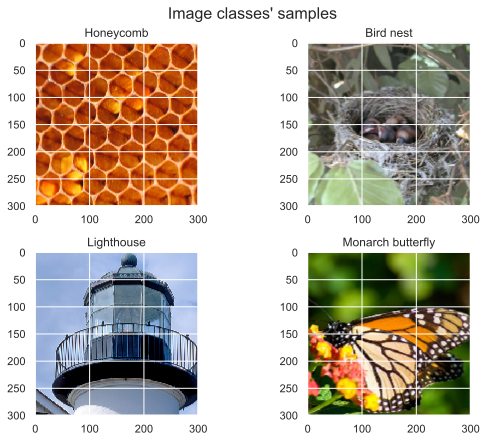

In [12]:
# Plot the choosen images to take a glimpse at each class
fig  = plt.figure(figsize=(8, 6))
for i, imgset in enumerate([honeycombs, birdnests, lighthouses, monarchbutterflies]):
    ax = fig.add_subplot(2, 2, i + 1)
    ax.imshow(imgset[idx])
    ax.set_title(img_titles[i])
fig.suptitle("Image classes' samples", y=1.02, fontsize=16)
fig.tight_layout();

## Feature extraction

 * **Generate first order texture measures as features for futher image classification**

In [13]:
def rgbmean_boxplot(img, title, ax):
    """
    Plot boxplots of row wise mean values for each RGB color channel of an input image
    """
    n_hpixels = img.shape[1] # number of pixels in a horizontal direction
    
    r = img[:, :, 0]
    g = img[:, :, 1]
    b = img[:, :, 2]
    
    # Calculate the variance for each rgb color channel in the horizontal direction
    r_mean = np.mean(r, axis=1)
    g_mean = np.mean(g, axis=1)
    b_mean = np.mean(b, axis=1)
    
    # Create a DataFrame to hold the information about a color and its row wise variances
    mean_values = np.r_[r_mean, g_mean, b_mean]
    color_channels = ['red' for i in range(0, len(r_mean))] + ['green' for i in range(0, len(g_mean))]\
                    + ['blue' for i in range(0, len(b_mean))]
    data = pd.DataFrame({'mean': mean_values, 'color channel': color_channels})
    
    bplot = sns.boxplot(x='color channel', y='mean', data=data, ax=ax)
    
    # Change default seaborn colors of boxplots into which ones we need
    # to make the plot more illustrative 
    for i, color in enumerate(['red', 'green', 'blue']):
        box = bplot.artists[i]
        box.set_facecolor(color)
        
    ax.set_title(title, fontsize=14)    

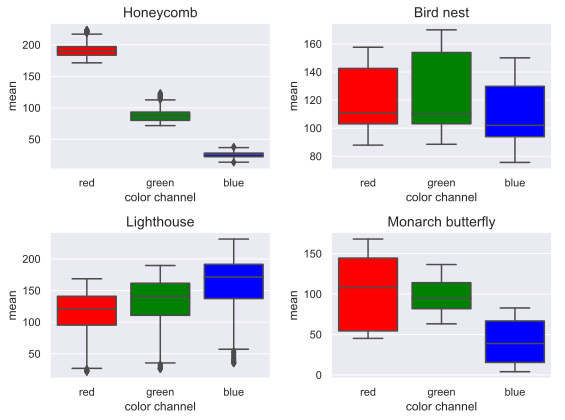

In [14]:
fig = plt.figure(figsize=(8, 6))

for i, imgset in enumerate([honeycombs, birdnests, lighthouses, monarchbutterflies]):
    ax = fig.add_subplot(2, 2, i + 1)
    rgbmean_boxplot(imgset[idx], img_titles[i], ax);

fig.tight_layout()

* For `honeycomb` images red channel dominates over other channels. Also there is a small variation in values of all three channels.
* For `Birdnest` images all three color channels contribute equally meaning that images are gray colored. Although values of all the channels vary in a huge range.
* For `Lighthouse` images blue channel dominates mostly following by a green channel that involves more shades of blue. Variation of values are more or less th same for all channels.
* For `Monarch butterfly` images red and green channels contribute mostly implying the occurance of various shades of red. Also the red color widely varies within an image. In additon to huge variation in red color, there is a largely ranged blue channel.


Visualizing color channels' distributions provides comprehensive overview of image texture and allows to guess dominating colors, shades, and even structures.

In [15]:
r_mean = [] # mean for red channel
g_mean = [] # mean for green channel
b_mean = [] # mean for blue channel

# iterate through all the image sets and calculate the mean for each of the channels
for img in np.vstack((honeycombs, birdnests, lighthouses, monarchbutterflies)):
    r = img[:, :, 0]
    g = img[:, :, 1]
    b = img[:, :, 2]
    
    r_mean.append(np.mean(r))
    g_mean.append(np.mean(g))
    b_mean.append(np.mean(b))

In [16]:
r_var = [] # variance for red channel
g_var = [] # variance for green channel
b_var = [] # variance for blue channel

# iterate through all the image sets and calculate the variance for each of the channels
for img in np.vstack((honeycombs, birdnests, lighthouses, monarchbutterflies)):
    r = img[:, :, 0]
    g = img[:, :, 1]
    b = img[:, :, 2]
    
    r_var.append(np.var(r))
    g_var.append(np.var(g))
    b_var.append(np.var(b))

* **Change the images into grayscale**

In [17]:
from skimage.color import rgb2gray

In [18]:
# Change the images into grayscale
honeycombs_gray256 = np.array([(255 * rgb2gray(img)).astype(np.uint8) for img in honeycombs])
birdnests_gray256 = np.array([(255 * rgb2gray(img)).astype(np.uint8) for img in birdnests])
lighthouses_gray256 = np.array([(255 * rgb2gray(img)).astype(np.uint8) for img in lighthouses])
monarchbutterflies_gray256 = np.array([(255 * rgb2gray(img)).astype(np.uint8) for img in monarchbutterflies])

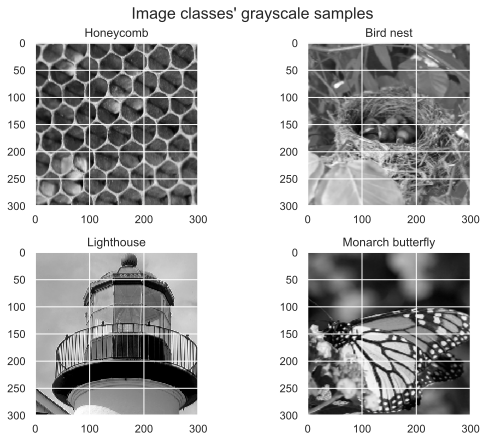

In [19]:
# Plot images samples of each class after turning all of them into grayscale mode
fig  = plt.figure(figsize=(8, 6))
for i, imgset in enumerate([honeycombs_gray256, birdnests_gray256, lighthouses_gray256, monarchbutterflies_gray256]):
    ax = fig.add_subplot(2, 2, i + 1)
    ax.imshow(imgset[idx], cmap=plt.cm.gray)
    ax.set_title(img_titles[i])
fig.suptitle("Image classes' grayscale samples", y=1.02, fontsize=16)
fig.tight_layout();

* **Reduce the quantization level of images to 8 levels for the reason of generating better features**.

Since GLCM matrix is a square-shape matrix having a number of rows and columns equals to the quantization level, it will be **memory-consuming** to store all possible combinations of gray levels for an image with 256 color values (grey levels). Additionally, if we preserved the original quantization level of images, we would result in GLCM matrix with over 65 thousands cells most of that are filled with zeros. Thus a *classifier* trained on features extracted from such a matrix will have very **bad performance**.

In [20]:
honeycombs_gray8 = np.array([(grayscale_img / 32).astype(np.uint8) for grayscale_img in honeycombs_gray256])
birdnests_gray8 = np.array([(grayscale_img / 32).astype(np.uint8) for grayscale_img in birdnests_gray256])
lighthouses_gray8 = np.array([(grayscale_img / 32).astype(np.uint8) for grayscale_img in lighthouses_gray256])
monarchbutterflies_gray8 = np.array([(grayscale_img / 32).astype(np.uint8) for grayscale_img in monarchbutterflies_gray256])

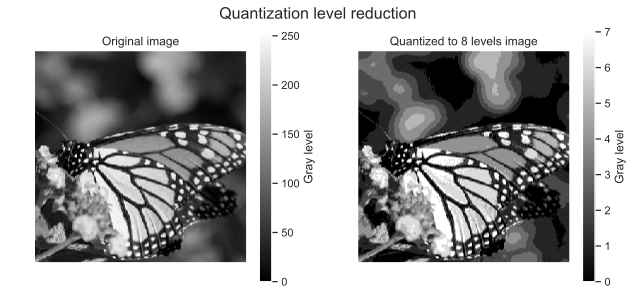

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
images = [monarchbutterflies_gray256[idx], monarchbutterflies_gray8[idx]]
titles = ['Original image', 'Quantized to 8 levels image']
for ax, img, title in zip(ax, images, titles):
    image = ax.imshow(img, cmap=plt.cm.gray)
    cb = plt.colorbar(image, ax=ax)
    cb.set_label('Gray level')
    ax.set_title(title)
    ax.axis('off')
    
fig.suptitle('Quantization level reduction', y=1.02, fontsize=16)
fig.tight_layout();

After reducing the quantization level, images have became *less sharp* and *more blurry*

* **Generate second order texture measures as features for futher image classification**

In [22]:
from skimage.feature import greycomatrix, greycoprops

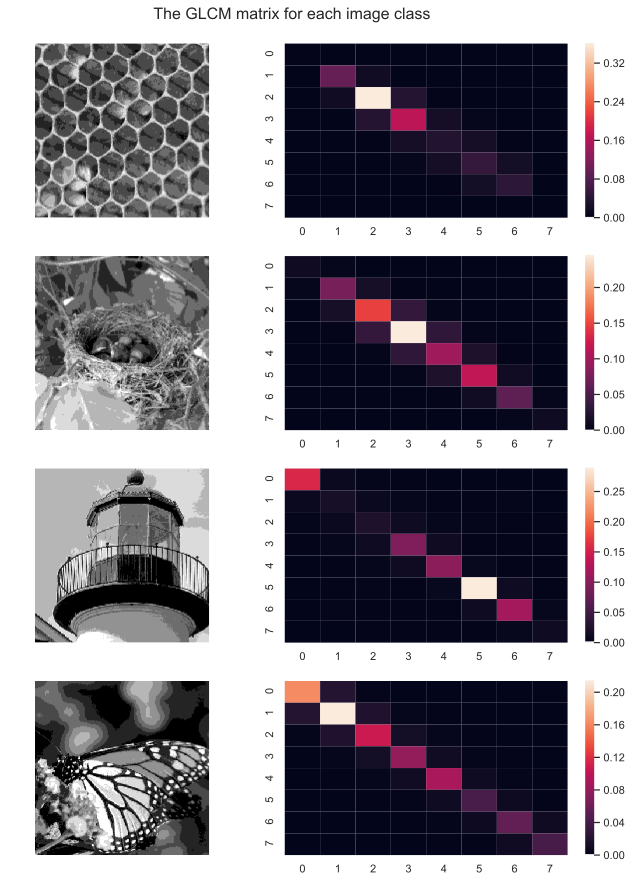

In [23]:
fig, ax = plt.subplots(4, 2, figsize=(10, 12))
images = [honeycombs_gray8[idx], birdnests_gray8[idx], lighthouses_gray8[idx], monarchbutterflies_gray8[idx]]

for i, img in enumerate(images):
    # Calculate the grey-level co-occurrence matrix for each image
    glcm = greycomatrix(img, [1], [0], levels=8, symmetric=True, normed=True)
    
    # Plot the image
    ax[i, 0].imshow(img, cmap=plt.cm.gray)
    ax[i, 0].axis('off')
    
    # Plot the visual representation of the GLCM matrix of the image
    sns.heatmap(glcm[:, :, 0, 0], ax=ax[i, 1])
    
fig.suptitle('The GLCM matrix for each image class', y=1.02, fontsize=16)   
fig.tight_layout();

In [24]:
# Extract features from GLCM matrix
contrast = []
dissimilarity = []
homogeneity = []
asm = []
correlation = []
max_prob = []
glcm_var = []

for img in np.vstack((honeycombs_gray8, birdnests_gray8, lighthouses_gray8, monarchbutterflies_gray8)):
    # Calculate the grey-level co-occurrence matrix
    glcm = greycomatrix(img, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=8, symmetric=True, normed=True)
    
    # Calculate texture properties of a GLCM
    # Pick up a measure at angle 0, i.e. horizontal GLCM
    contrast.append(greycoprops(glcm, 'contrast')[0, 0])
    dissimilarity.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    homogeneity.append(greycoprops(glcm, 'homogeneity')[0, 0])
    asm.append(greycoprops(glcm, 'ASM')[0, 0])
    correlation.append(greycoprops(glcm, 'correlation')[0, 0])
    max_prob.append(glcm[:, :, 0, 0].max())
    glcm_var.append(glcm[:, :, 0, 0].var())

**Local Binary Pattern** (LBP) is an invariant descriptor that can be used for texture classification. LBP labels the pixels of an image by looking at points surrounding a central point (pixel) and tests whether the surrounding points (pixels) are greater than or less than the central point. The result is given as a bimary number.

*Algorithm*:
1. Define a sliding window (usually 3x3 pixels matrix containing the intensity of each pixel) based on two parameters:
    * radius: is used to build the circle and represents the radius around the central pixel.
    * neighbors: a number of neigboring pixels to build the circular local binary pattern. It is usually set to 8 (left-top, left-middle, left-bottom, right-top, etc)
2. Follow the pixels along a circle, i.e. clockwise or counter-clockwise.
3. Where the center pixel's value (also known as the threshold) is greater than the neighbor's value, set it to the value of 0. Otherwise, set to 1. This gives an 8-digit binary number.
4. Convert this binary number to a decimal value and set it to the central value of the matrix, which is actually a pixel from the original image.
5. Repeat steps from 1 to 4 for each pixel

Using the LBP combined with histograms we can represent an image with a simple data vector and make a good measure to classify textures.

Using the image generated as a result of described algorithm, we divide it into regions (usually 8x8 or 16x16). For each region we can compute a histogram representing the occurrence of each decimal value. If we define a number of neighboring pixels as value of 8, then we end up with 256 possible values (from 0 to 255). Thus, this histogram will be composed of 256 bins. Optionally the histogram can be normalized.

Afterwards concatenate all the histograms. This gives a feature vector for the image, which can be used to detect texture.

The feature vector can also be processed using the Support vector machine, extreme learning machines, or some other machine-learning algorithm to classify images. Such classifiers can be used for face recognition or texture analysis.


**References**:
1. Local binary patterns https://en.wikipedia.org/wiki/Local_binary_patterns
2. Face Recognition: Understanding LBPH Algorithm https://towardsdatascience.com/face-recognition-how-lbph-works-90ec258c3d6b
3. Local Binary Pattern for texture classification http://scikit-image.org/docs/stable/auto_examples/features_detection/plot_local_binary_pattern.html#sphx-glr-auto-examples-features-detection-plot-local-binary-pattern-py

In [25]:
from skimage.feature import local_binary_pattern

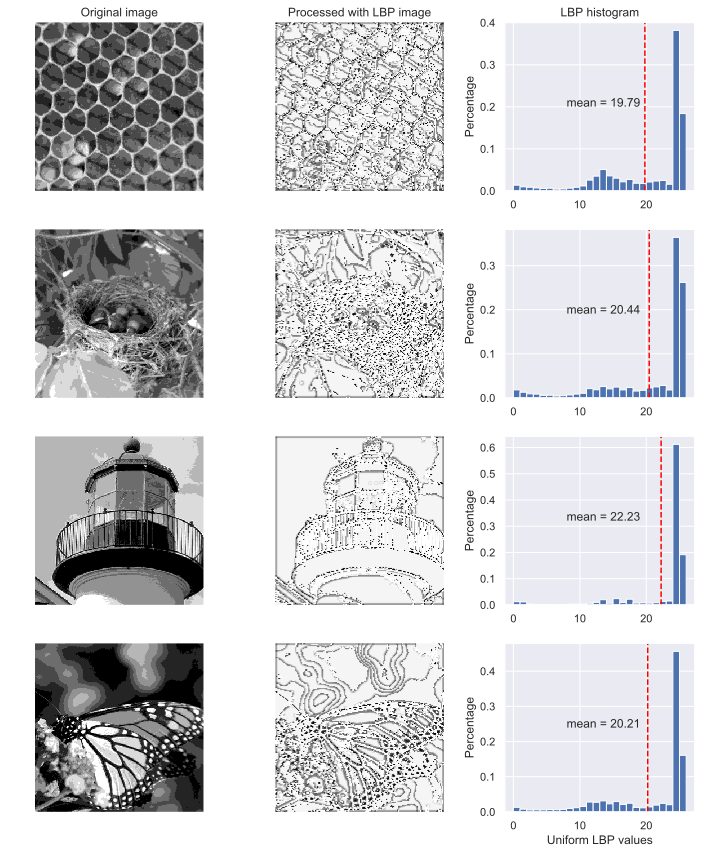

In [26]:
# Demonstration of LBP over image classes samples
# Apply LBP to each class sample

# Settings for LBP
radius = 3
n_points = 8 * radius
method = 'uniform'


def lbp_hist(lbp, ax):
    """Plot a histogram of frequency of pixel intensity values ocuring in the image processed by LBP algorithm"""
    n_bins = int(lbp.max() + 1)
    
    ax.hist(lbp.ravel(), bins=n_bins, range=(0, n_bins), normed=True)
    ax.set_ylabel('Percentage')

    
fig, ax = plt.subplots(4, 3, figsize=(10, 12))
images = [honeycombs_gray8[idx], birdnests_gray8[idx], lighthouses_gray8[idx], monarchbutterflies_gray8[idx]]

for i, img in enumerate(images):
    lbp = local_binary_pattern(img, n_points, radius, method)
    
    # Plot the original image
    ax[i, 0].imshow(img, cmap=plt.cm.gray)
    ax[i, 0].axis('off')
    
    # Plot LBP image
    ax[i, 1].imshow(lbp, cmap=plt.cm.gray)
    ax[i, 1].axis('off')
    
    # Plot LBP histogram
    lbp_hist(lbp, ax[i, 2])
    mean = ax[i, 2].axvline(lbp.mean(), linestyle='--', color='red')
    ax[i, 2].text(8, ax[i, 2].get_ylim()[1] / 2, f'mean = {np.round(lbp.mean(), 2)}')
    
ax[0, 0].set_title('Original image')
ax[0, 1].set_title('Processed with LBP image')
ax[0, 2].set_title('LBP histogram')
ax[3, 2].set_xlabel('Uniform LBP values')
fig.tight_layout();

In [27]:
# Extract features from LBP histograms of images
lbp_mean = []
lbp_var = []


for img in np.vstack((honeycombs_gray8, birdnests_gray8, lighthouses_gray8, monarchbutterflies_gray8)):
    # Apply LBP to an image
    lbp = local_binary_pattern(img, n_points, radius, method).astype(np.uint8)
       
    lbp_mean.append(lbp.mean())
    lbp_var.append(lbp.var())

* **Configure all extracted features into a matrix of samples $(X_0, y_0), (X_1, y_1), \ldots, (X_n, y_n)$**

In [28]:
feature_names = ['Red channel mean', 'Grean channel mean', 'Blue channel mean',
                'Red channel variance', 'Green channel variance', 'Blue channel variance',
                'Contrast', 'Dissimilarity', 'Homogeneity', 'ASM', 'Correlation', 'Maximum Probability',
                 'GLCM variance', 'LBP values mean', 'LBP values variance', 'Class']

# Encode image classes 'honeycomb', 'bird nest', 'light house' and 'monarch butterfly' with 0, 1, 2, 3 values respectively
honeycomb_labels = np.zeros(honeycombs_gray8.shape[0], dtype=np.int8)
birdnest_labels = np.ones(birdnests_gray8.shape[0], dtype=np.int8)
lighthouse_labels = 2 * np.ones(lighthouses_gray8.shape[0], dtype=np.int8)
monarchbutterfly_labels = 3 * np.ones(monarchbutterflies_gray8.shape[0], dtype=np.int8)
# Form a vector of class labels 
class_labels = np.r_[honeycomb_labels, birdnest_labels, lighthouse_labels, monarchbutterfly_labels]

In [29]:
from collections import OrderedDict

In [30]:
feature_values = [r_mean, g_mean, b_mean, r_var, g_var, b_var, contrast, dissimilarity, homogeneity, asm, correlation, max_prob,
                 glcm_var, lbp_mean, lbp_var, class_labels]
# Create a dictionary of pairs feature_name -> feature_values
data_dict = OrderedDict(zip(feature_names, feature_values))

# Create a DataFrame to summarize all extracted features 
data = pd.DataFrame(data_dict)

In [31]:
data.head()

,Red channel mean,Grean channel mean,Blue channel mean,Red channel variance,Green channel variance,Blue channel variance,Contrast,Dissimilarity,Homogeneity,ASM,Correlation,Maximum Probability,GLCM variance,LBP values mean,LBP values variance,Class
0,186.702322,105.224244,38.226378,1110.311577,1700.274959,1273.172198,0.158863,0.152598,0.924328,0.162788,0.945678,0.232821,0.002299,20.452578,33.152040,0
1,211.939511,111.140244,33.686589,1460.033252,2134.612576,1470.112496,0.209588,0.173958,0.916528,0.150620,0.943736,0.221695,0.002109,20.753778,32.827330,0
2,166.727211,104.612322,30.403244,1853.258086,2098.454339,1506.204661,0.119052,0.115975,0.942320,0.223537,0.967619,0.408317,0.003249,20.129667,28.763364,0
3,152.167189,91.264811,35.719633,570.763615,805.383108,676.006783,0.230190,0.216410,0.893171,0.214542,0.855076,0.342943,0.003108,20.572978,41.364852,0
4,123.488622,98.753767,77.688411,5412.276782,5641.555425,5443.060435,1.366388,0.671962,0.728729,0.068766,0.871545,0.161717,0.000830,18.349467,58.349473,0


In [32]:
data.info() # make sure that all columns have the same number of instances and there is no undefined values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 16 columns):
Red channel mean          160 non-null float64
Grean channel mean        160 non-null float64
Blue channel mean         160 non-null float64
Red channel variance      160 non-null float64
Green channel variance    160 non-null float64
Blue channel variance     160 non-null float64
Contrast                  160 non-null float64
Dissimilarity             160 non-null float64
Homogeneity               160 non-null float64
ASM                       160 non-null float64
Correlation               160 non-null float64
Maximum Probability       160 non-null float64
GLCM variance             160 non-null float64
LBP values mean           160 non-null float64
LBP values variance       160 non-null float64
Class                     160 non-null int8
dtypes: float64(15), int8(1)
memory usage: 19.0 KB


In [33]:
# Separate the data containing features from class labels
y = data['Class'].values # target values
X = data.drop('Class', axis=1).values # features, data matrix

* **Standardization of the feature values**

In [34]:
from sklearn.preprocessing import scale

In [35]:
# After centering the average value for each feature will be 0, and after scaling the standard deviation for the values
# for each feature will be 1
standardized_data = scale(X)

* **Principal Component Analysis**

In [36]:
from sklearn.decomposition import PCA

In [37]:
pca = PCA(random_state=17) # create an istance of PCA class and fix a seed for the reproducibility of results
pca.fit(standardized_data)

pca_data = pca.transform(standardized_data)

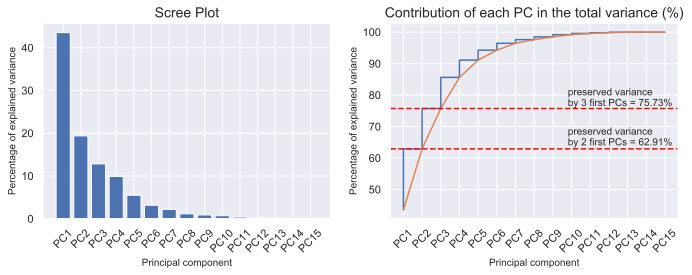

In [38]:
# Demonstrate PCA results

# Compute the percentage of variation each principal component accounts for
pca_variations = np.round(pca.explained_variance_ratio_ * 100, 2)

# Create lables for the Scree plot: one lable per each component
pca_labels = ['PC%s' %i for i in range(1, len(pca.components_) + 1)]

fig, ax = plt.subplots(1, 2, figsize=((10, 4)))

# Scree Plot
ax[0].bar(x=range(1, len(pca.components_) + 1), height=pca_variations, tick_label=pca_labels)
ax[0].set_xlabel('Principal component', fontsize=10)
ax[0].xaxis.set_tick_params(rotation=45)
ax[0].set_ylabel('Percentage of explained variance', fontsize=10)
ax[0].set_title('Scree Plot', fontsize=14)

# Draw a plot illustrating the impact of each component on total variance
ax[1].step(range(1, len(pca.components_) + 1), np.cumsum(pca_variations))
ax[1].plot(range(1, len(pca.components_) + 1), np.cumsum(pca_variations))

ax[1].axhline(np.cumsum(pca_variations)[2], linestyle='--', color='red')
ax[1].text(9.8, 76.5, 'preserved variance\nby 3 first PCs = {:.2f}%'.format(np.cumsum(pca_variations)[2]), fontsize=10)

ax[1].axhline(np.cumsum(pca_variations)[1], linestyle='--', color='red')
ax[1].text(9.8, 64, 'preserved variance\nby 2 first PCs = {:.2f}%'.format(np.cumsum(pca_variations)[1]), fontsize=10)

ax[1].set_xticks(range(1, len(pca.components_) + 1))
ax[1].set_xticklabels(pca_labels)
ax[1].set_xlabel('Principal component', fontsize=10)
ax[1].xaxis.set_tick_params(rotation=45)
ax[1].set_ylabel('Percentage of explained variance', fontsize=10)
ax[1].set_title('Contribution of each PC in the total variance (%)', fontsize=14)

fig.tight_layout();

As we can see through the plots above, *two first PCs* account up to **63% of the total variation of data**, meanwile *three first PCs* explain approximately **76% of the total variation**. Based on that numbers, it would be better to pick three first PCs to project the data onto them for the reason of more illustrative data visualization.

Let's identify the featers along which most of the data are spread out by picking loading scores of the first PC

In [39]:
pc1_loading_scores = pd.Series(pca.components_[0], index=feature_names[:-1])
sorted_pc1_loading_scores = pc1_loading_scores.abs().sort_values(ascending=False)

In [40]:
sorted_pc1_loading_scores

LBP values variance       0.355851
Homogeneity               0.353654
Dissimilarity             0.348174
GLCM variance             0.339609
ASM                       0.339609
Maximum Probability       0.317798
Contrast                  0.316675
LBP values mean           0.294290
Correlation               0.197771
Green channel variance    0.185939
Red channel variance      0.124557
Blue channel mean         0.112028
Blue channel variance     0.060253
Red channel mean          0.054163
Grean channel mean        0.014283
dtype: float64

The data are mostly spread out along the `LBP values variance` and `Homogeneity ` axes and only a little bit spread out along `Blue channel variance`, `Red channel mean`, and `Grean channel mean` axes. These findings let us assume that *first order texure measures* like **mean** and **variance** of color channels are less valuable for distinguishing classes than *second order texture measures* derived from **GLCM** of images.

Now let's have a look at the data in **LBP values variance** and **Homogeneity** feature space.

In [41]:
label_names = ['honeycomb', 'bird nest', 'lighthouse', 'monarch butterfly']
markers = list('osDv')
colors = ['orange', 'gray', 'blue', 'red']
n_classes = 4

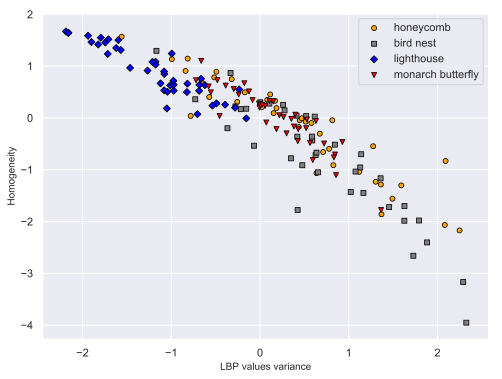

In [42]:
scaled_data = pd.DataFrame(standardized_data, columns=feature_names[:-1])

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for i, label, marker, color in zip (range(n_classes), label_names, markers, colors):
    ax.scatter(scaled_data[y == i]['LBP values variance'], scaled_data[y == i]['Homogeneity'], c=color, s=25, marker=marker,
               edgecolors='black', linewidths=0.8, label=label)
ax.set_xlabel('LBP values variance', fontsize=10)
ax.set_ylabel('Homogeneity', fontsize=10)
ax.legend();

The above figure demonstrates how the data are spread out along `LBP values variance` and `Homogeneity` axes.

It's quite clear to see how **Lighthouse** samples are clustered in the top left corner, whereas **Bitdnest** and **Honeycomb** samples are widely spread out along `LBP values variance` axis. **Monarch butterfly** data points are placed relatively close to each other but it's very difficult to separate them from other classes' samples.

Also the plot provides us information about the relationships between `LBP values variance` and `Homogeneity` feaures. The bigger `LBP values variance`, the smaller `Homogeneity` meaning the *negative correlation* between these two features.

In [43]:
pca_df = pd.DataFrame(pca_data, columns=pca_labels)

pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
0,-1.426440,0.741762,-1.598778,2.650826,-0.133527,-0.474061,0.930025,-0.377144,-0.135940,0.176113,-0.110229,0.155921,-0.169125,-0.000646,3.082987e-16
1,-1.112350,0.313757,-1.402294,2.962592,0.383025,-0.387155,1.373380,-0.570518,-0.134335,0.060368,-0.132247,0.119038,-0.160219,-0.001684,3.904700e-16
2,-2.542296,0.839259,-1.739932,1.834281,0.739309,-0.733722,-0.020072,-0.186149,-0.019865,0.311928,-0.373740,-0.230692,0.002772,0.000398,8.037039e-17
3,-1.517362,2.875522,-0.992832,1.884105,-0.043311,-0.487400,0.521878,0.112778,-0.331625,-0.086085,0.383626,-0.050200,0.001521,0.001673,-5.248839e-16
4,4.768341,-0.097203,0.288850,-1.261878,0.982560,-0.727895,-0.697486,-0.268741,-0.007208,0.852342,-0.315878,0.266364,-0.015592,-0.007161,7.071101e-17


In [44]:
from mpl_toolkits.mplot3d.axes3d import Axes3D

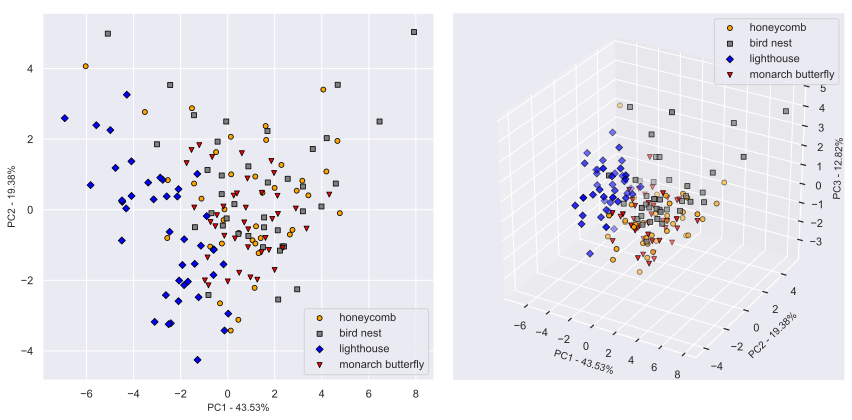

In [45]:
# Plot data set representation in 3D space1
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
for i, label, marker, color in zip (range(n_classes), label_names, markers, colors):
    ax.scatter(pca_df[y == i]['PC1'], pca_df[y == i]['PC2'], c=color, s=25, marker=marker,
               edgecolors='black', linewidths=0.8, label=label)
ax.set_xlabel('PC1 - {}%'.format(pca_variations[0]), fontsize=10)
ax.set_ylabel('PC2 - {}%'.format(pca_variations[1]), fontsize=10)
ax.legend()

ax = fig.add_subplot(1, 2, 2, projection='3d')
for i, label, marker, color in zip (range(n_classes), label_names, markers, colors):
    ax.scatter(pca_df[y == i]['PC1'], pca_df[y == i]['PC2'], pca_df[y == i]['PC3'], c=color, s=25, marker=marker,
               edgecolors='black', linewidths=0.8, label=label)
ax.set_xlabel('PC1 - {}%'.format(pca_variations[0]), fontsize=10)
ax.set_ylabel('PC2 - {}%'.format(pca_variations[1]), fontsize=10)
ax.set_zlabel('PC3 - {}%'.format(pca_variations[2]), fontsize=10)
ax.legend()
fig.tight_layout();

Visualizing our data in 2D space of first two PCs doesn't give reasonable results except that we can still easily recongnize **Lighthouse** samples clustering around each other.

Picking first three PCs, we have got a 3D visualization of our data which provides more detailed insight into feature relationships. Now we can catch at least two clearly seperated classes like **Lighthouse** and **Birdnest**. It's a bit hard to recognize other two classes, but **Honeycomb** and **Monarch butterfly** samples seem to be clustering too.

More that that, through 3D illustration we can say that there are a lot of outliers in **Lighthouse** samples which are widely spread along PC1 and PC3.

Also we can observe that in the centre the cloud of samples is quite messy.

* **SOM illustration of feature relationships**

In [46]:
from minisom import MiniSom

In [47]:
# Initialize SOM

# To define a size of the SOM grid we use a rule of the thumb.
# According to it, the total number on neurons equals 5*sqrt(N), where N is a number of samples in the dataset.
# In our case n_samples = 160, thus n_neurons ~ 63.25. Hence a lattice 8-by-8 should be set.
som = MiniSom(8, 8, 15, sigma=0.825, learning_rate=0.1, neighborhood_function='gaussian', random_seed=19)

# Initialize SOM's weights
som.pca_weights_init(standardized_data)

In [48]:
%%time

# Training
som.train_batch(standardized_data, num_iteration=10000)

Wall time: 7.49 s


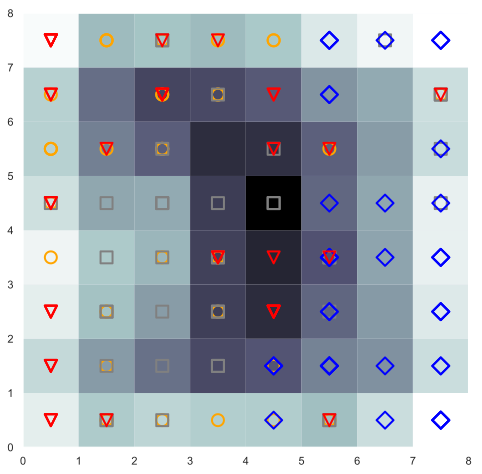

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# Plot the distance map of the weights of SOM's neurons
ax.pcolormesh(som.distance_map().T, cmap=plt.cm.bone_r)

for i, sample in enumerate(standardized_data):
    bmu = som.winner(sample) # get the best matching unit for an input vector (sample)
    # Place a marker of corresponding class on a position of a winner-takes-all neuron for the current sample 
    ax.plot(bmu[0] + .5, bmu[1] + .5, marker=markers[y[i]], markerfacecolor='None', markeredgecolor=colors[y[i]],
            markersize=12, markeredgewidth=2)

In [50]:
from matplotlib.gridspec import GridSpec

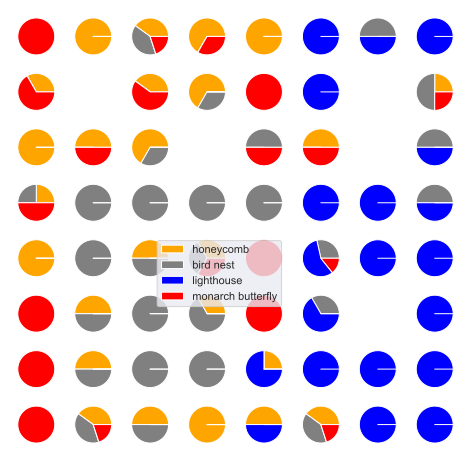

In [51]:
named_labels = ['honeycomb' for i in range(0, honeycomb_labels.shape[0])]\
             + ['bird nest' for i in range(0, birdnest_labels.shape[0])]\
             + ['lighthouse' for i in range(0, lighthouse_labels.shape[0])]\
             + ['monarch butterfly' for i in range(0, monarchbutterfly_labels.shape[0])]
            
# dictionary containing the number of samples from a given label
# that have been mapped in a SOM's map unit having a position i,j
labels_map = som.labels_map(standardized_data, named_labels)

plt.figure(figsize=(8, 8))
som_grid = GridSpec(8, 8)

for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names]
    plt.subplot(som_grid[7 - position[1], position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs, colors=colors)
plt.legend(patches, label_names, ncol=1);

SOM illustration gives simillar results. The most separable classes are **Lighthouse** and **Birdnest**. **Honeycomb** and **Monarch butterfly** samples look very alike. Also there are a plenty of samples that are really challenging for SOM algorithm to assign to one of classes.

## Calculations

In [52]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold

### Classifier 1: kNN

In [53]:
from sklearn.neighbors import KNeighborsClassifier

While applying K-fold cross validation to model trainig, we use a *stratified* version to preserve the class distribution within all the sets and ensure homogeneity of training, validation and test sets for more accurate results.

In [54]:
X = standardized_data # data matrix
n_instances, n_features = X.shape

outer_skf = StratifiedKFold(n_splits=10, random_state=1234)
inner_skf = StratifiedKFold(n_splits=10, random_state=1234)

In [55]:
k_range = range(1, 21) # values of k for kNN model selection
k_best = [] # list of k values corresponding to models which have best performance

In [56]:
cv_round = 0 # hold the current round of cross validation in the outer loop

# confusion matrix to summarize a classifier's performace on each of test folds
final_cm = np.zeros((n_classes, n_classes), dtype=np.int) 

for train_index, test_index in outer_skf.split(X, y):   
    # split the original dataset into training and test sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    avg_accs = [] # list to store average accuracy of each model with a certain value of k
    
    # Iterate over defined range of values of k for hyperparameter tunning
    for k in k_range:
        scores = [] # list to store accuracy values over each round
        
        # Perform 10-k cross validation on training test for model selection
        for subtrain_index, validation_index in inner_skf.split(X_train, y_train):
            # Split training data into training and validation sets
            X_subtrain, X_valid = X_train[subtrain_index], X_train[validation_index]
            y_subtrain, y_valid = y_train[subtrain_index], y_train[validation_index]
            
            # Create an instance of KNN classifier by specifing a number of neighbors
            knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
            # Train the model and make predictions on the validation set
            knn.fit(X_subtrain, y_subtrain)
            y_pred = knn.predict(X_valid)
            
            scores.append(accuracy_score(y_valid, y_pred))
            
        avg_accs.append(np.mean(scores))
    
    # Based on the accuracy, choose that value of k which corresponds to the best-performing model
    k_best.append(k_range[avg_accs.index(max(avg_accs))])
    
    # Use the complete training set for model fitting
    knn = KNeighborsClassifier(n_neighbors=k_best[cv_round], weights='distance')
    knn.fit(X_train, y_train)
    y_predicted = knn.predict(X_test)
    
    cm = confusion_matrix(y_test, y_predicted) # compute a local confusion matrix based on the current round of outer cv
    
    final_cm += cm
    # Print results of the current round of outer cross validation
    print('Outer CV Round: {:2}  Best k-value: {:2}  Accuracy: {:.2%}'.format(cv_round + 1, k_best[cv_round],
                                                                               accuracy_score(y_test, y_predicted)))
    cv_round += 1 # move on to the next round
print('The estimated accuracy of KNN method based on 10-by-10 nasted cross validation is {:.2%}'.format(np.sum(np.diag(final_cm)) / n_instances))            

Outer CV Round:  1  Best k-value: 12  Accuracy: 82.35%
Outer CV Round:  2  Best k-value:  6  Accuracy: 47.06%
Outer CV Round:  3  Best k-value:  6  Accuracy: 68.75%
Outer CV Round:  4  Best k-value:  6  Accuracy: 75.00%
Outer CV Round:  5  Best k-value: 10  Accuracy: 56.25%
Outer CV Round:  6  Best k-value:  7  Accuracy: 62.50%
Outer CV Round:  7  Best k-value:  3  Accuracy: 56.25%
Outer CV Round:  8  Best k-value:  7  Accuracy: 68.75%
Outer CV Round:  9  Best k-value:  9  Accuracy: 62.50%
Outer CV Round: 10  Best k-value: 14  Accuracy: 71.43%
The estimated accuracy of KNN method based on 10-by-10 nasted cross validation is 65.00%


In [57]:
def plot_confusion_matrix(cm):
    """Plot a visual representation of a confusion matrix as a heatmap"""
    df = pd.DataFrame(cm, index=img_titles, columns=img_titles)
    
    hm = sns.heatmap(df, annot=True, cmap=plt.cm.Blues, cbar=False)
    hm.set_xlabel('Predicted', fontsize=12, fontweight='bold')
    hm.set_ylabel('Actual', fontsize=12, fontweight='bold');

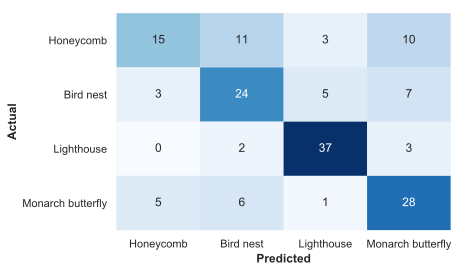

In [58]:
plot_confusion_matrix(final_cm)

Here is a visual representation of confusion matrix for KNN classifier, which summurizes results of 10-by-10 nasted cross validation. Cells lying on a diagonal of this matrix represent a number of samples, which were correctly classified. That's good to see that for all image classes the majority of samples were assigned to appropriate categories.
Nevertheless, the classifier's accuracy is relatively low, and the confusion matrix provides some interesting features, which are good to notice.

* the classifier fails to recognize a `honeycomb`. A number of correctly classified `honeycomb` images are very close to the number of `honeycomb` samples, which were classified as monarch `butterflies` or `bird nests`.
* `bird nest` and `monarch butterfly` images are very likely to be classified correctly. The ratio of correctly classified images to incorrectly classified is 24:15 for `bird nest` and 28:12 for `monarch butterfly`.
* the most easy-to-recognize image class for the KNN classifier is the `lighthouse`. The vast majority of `lighhouse` samples were correctly classified. However, it's not a huge surprise, since there is abundant evidence through dataset illustration of tight clustering of `lighthouse` images in the feature space.

Now let's have a look at which best values of k were the most frequent while performing 10-k cross validation for model selection

In [59]:
pd.Series(k_best).value_counts()

6     3
7     2
14    1
12    1
10    1
9     1
3     1
dtype: int64

As we can see from a frequency list of best values for *k hyperparameter*, values such as **6 and 7** have been chosen as best ones more often than other values. Also best values of k has ranged from **9 to 14**.

### Classifier 2: Logisitic Regression with regularization term

In [60]:
from sklearn.linear_model import LogisticRegression

In [61]:
C_range = np.linspace(-5, 5, 20)
C_best = [] # hold the best values of regularization term based on cross validation

In [62]:
cv_round = 0 # hold the current round of cross validation in the outer loop

# confusion matrix to summarize a classifier's performace on each of test folds
final_cm = np.zeros((n_classes, n_classes), dtype=np.int) 

for train_index, test_index in outer_skf.split(X, y):   
    # split the original dataset into training and test sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    avg_accs = [] # list to store average accuracy of each model with a certain value of C
    
    # Iterate over defined range of values of C for hyperparameter tunning
    for C in C_range:
        scores = [] # list to store accuracy values over each round
        
        # Perform 10-k cross validation on training test for model selection
        for subtrain_index, validation_index in inner_skf.split(X_train, y_train):
            # Split training data into training and validation sets
            X_subtrain, X_valid = X_train[subtrain_index], X_train[validation_index]
            y_subtrain, y_valid = y_train[subtrain_index], y_train[validation_index]
            
            # Create an instance of regularized Logistic Regressioin classifier with specified regularization parameter
            logit = LogisticRegression(C=2**C, solver='lbfgs', multi_class='multinomial', max_iter=1000, random_state=1234)
            # Train the model and make predictions on the validation set
            logit.fit(X_subtrain, y_subtrain)
            y_pred = logit.predict(X_valid)
            
            scores.append(accuracy_score(y_valid, y_pred))
            
        avg_accs.append(np.mean(scores))
    
    # Based on the accuracy, choose that value of C which corresponds to the best-performing model
    C_best.append(C_range[avg_accs.index(max(avg_accs))])
    
    # Use the complete training set for model fitting
    logit = LogisticRegression(C=2**C_best[cv_round], solver='lbfgs', multi_class='multinomial', max_iter=1000, random_state=1234)
    logit.fit(X_train, y_train)
    y_predicted = logit.predict(X_test)
    
    cm = confusion_matrix(y_test, y_predicted) # compute a local confusion matrix based on the current round of outer cv
    
    final_cm += cm
    # Print results of the current round of outer cross validation
    print('Outer CV Round: {:2}   Best C-value: 2^{:5.1f}   Accuracy: {:.2%}'.format(cv_round + 1, C_best[cv_round],
                                                                               accuracy_score(y_test, y_predicted)))
    cv_round += 1 # move on to the next round          

Outer CV Round:  1   Best C-value: 2^  1.3   Accuracy: 88.24%
Outer CV Round:  2   Best C-value: 2^ -1.8   Accuracy: 70.59%
Outer CV Round:  3   Best C-value: 2^ -0.8   Accuracy: 68.75%
Outer CV Round:  4   Best C-value: 2^  1.3   Accuracy: 75.00%
Outer CV Round:  5   Best C-value: 2^  1.3   Accuracy: 56.25%
Outer CV Round:  6   Best C-value: 2^ -0.8   Accuracy: 81.25%
Outer CV Round:  7   Best C-value: 2^  1.8   Accuracy: 93.75%
Outer CV Round:  8   Best C-value: 2^  2.4   Accuracy: 93.75%
Outer CV Round:  9   Best C-value: 2^  0.8   Accuracy: 87.50%
Outer CV Round: 10   Best C-value: 2^ -0.3   Accuracy: 78.57%


In [63]:
print('The estimated accuracy of Regularized Logistic Regression model based on 10-by-10 nasted cross validation is {:.2%}'.format(np.sum(np.diag(final_cm)) / n_instances))

The estimated accuracy of Regularized Logistic Regression model based on 10-by-10 nasted cross validation is 79.38%


Applying `Regularized Logistic Regression` to our data, we have managed to increase the total accuracy to the value very close to **80%**, which is **15%** more than the `k Nearest Neighbors` performance.

Now let's have a look at the confusion matrix produced by linear model

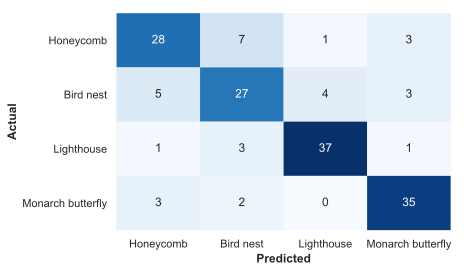

In [64]:
plot_confusion_matrix(final_cm)

In comparison with previous results of kNN classfier, we should point out following

* for all the classes the number of correctly classified samples is increased, and most of the samples have been assigned to appropriate classes 
* the most significant rise in accuracy has been seen for `honeycomb` class. Now the ratio of the number of correctly classified samples and the number of misclassified ones is **28:11** against **15:24** in case of kNN.
* the number of true positives for `bird nest` class is rised by 3 points, for `lighthouse` class by 1 point, and for `monarch butterfly` class by 7 points respectively.

Count the most frequent values for `C` parameter during the model selection

In [65]:
pd.Series(np.round(2**np.array(C_best), 2)).value_counts()

2.49    3
0.58    2
5.16    1
0.83    1
1.73    1
0.28    1
3.59    1
dtype: int64

Values of **2.49** corresponding to $2^{1.3}$ and **0.58** corresponding to $2^{-0.8}$ have occured mostly. However, many other values have been choosen as optimal for regularization term, which is really confusing. There are both small and big values for regularization parameter. It means that in some cases the model is more complex with huge values for regularization term, i.e. the cost of error is high, and in other cases with small values of `C` parameter the built model tends to be more simple and we don't penalize it for error too much.

### Classifier 3: Multi-layer perceptron with 1 hidden layer and early stop commitee

In [66]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [67]:
early_stopping_monitor = EarlyStopping(patience=3)

In [68]:
hidden_units_range = range(10, 21)
best_n_units = []

In [69]:
def mlp_classifier(input_shape, n_units, optimizer, hidden_layer_activation='linear', metrics=['accuracy']):
    """
    Create and configure Multi-layer perceptron with one hidden layer and early stopping for multi-class softmax classification.
    """
    model = Sequential() # create an instance of Sequential class model in Keras, which is defined as a linear stack of layers
    
    # Specify an input shape for the input layer, the number of units for a hidden layer, and activation function used to fire
    # a neuron.
    model.add(Dense(n_units, activation=hidden_layer_activation, input_dim=input_shape))
    
    # Add an output layer composed of the number of units that is equal to a number of classes. Use Softmax activation function
    # to ensure that sum of output probabilites for each class is 1.
    model.add(Dense(n_classes, activation='softmax'))

    # Configure the learning process by defining optimizer, loss function to minimize and
    # a list of metrics used to evaluate the model's performance
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=metrics)
    return model

In [70]:
from sklearn.model_selection import train_test_split

For the model selection and model evaluation of **MLP**, we split the data into two sets: *training and test*. Then we perform `10 fold cross validation` over the trainig set for *parameter tunning* (chasing the optimal number of units of a hidden layer which yields the better generalization accuracy) and *model selection*, in the meantime we keep independent the test set for final *evaluation of model performance*. After identifying the best number of hidden units, we fit the model to the whole training set and evaluate its performance on test set.

The main reason for such approach is `heavy computations` when implementing **MLP with one hidden layer**. From our personal experience, it's very **costly** to perform nested cross validation.

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1234)

for label, dataset in (('Training set', X_train), ('Test set', X_test)):
    print('== {} =='.format(label))
    print('# samples: {}'.format(dataset.shape[0]))
    print()

== Training set ==
# samples: 144

== Test set ==
# samples: 16



In [72]:
skf = StratifiedKFold(n_splits=10, random_state=1234)

In [73]:
results = [] # hold cross validation results for each value of hidden units from a defined range
for units in range(5, 21):
    scores = []
    for subtrain_index, valid_index in skf.split(X_train, y_train):   
        # split the original dataset into training and test sets
        X_subtrain, X_valid = X_train[subtrain_index], X_train[valid_index]
        y_subtrain, y_valid = y_train[subtrain_index], y_train[valid_index]
        y_subtrain_encoded = to_categorical(y_subtrain)
        y_valid_encoded = to_categorical(y_valid)
    
        mlp = mlp_classifier(n_features, units, 'adam', 'relu')
        # Train the model and make predictions on the validation set
        mlp.fit(X_subtrain,
                y_subtrain_encoded,
                epochs=20,
                verbose=0,
                callbacks=[early_stopping_monitor],
                validation_data=(X_valid, y_valid_encoded),
                initial_epoch=1)
        # Make prediction on validation set
        y_pred_prob = mlp.predict(X_valid)
        y_pred = np.argmax(y_pred_prob, axis=1)
        scores.append(accuracy_score(y_valid, y_pred)) 
    average_acc = np.mean(scores) # calculate the mean accuracy over 10 rounds
    results.append({'n_units': units, 'avg_acc': average_acc})
    
    print('# units: {:2d}  Average accuracy: {:.2%}'.format(units, average_acc))
print('Total number of samples used for training: {}'.format(X_subtrain.shape[0]))
print('Total number of samples used for model performance evaluating: {}'.format(X_valid.shape[0]))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
# units:  5  Average accuracy: 36.21%
# units:  6  Average accuracy: 34.28%
# units:  7  Average accuracy: 36.64%
# units:  8  Average accuracy: 41.82%
# units:  9  Average accuracy: 37.78%
# units: 10  Average accuracy: 42.45%
# units: 11  Average accuracy: 45.03%
# units: 12  Average accuracy: 47.50%
# units: 13  Average accuracy: 47.95%
# units: 14  Average accuracy: 49.02%
# units: 15  Average accuracy: 41.08%
# units: 16  Average accuracy: 54.26%
# units: 17  Average accuracy: 53.83%
# units: 18  Average accuracy: 46.11%
# units: 19  Average accuracy: 48.84%
# units: 20  Average accuracy: 46.76%
Total number of samples used for training: 132
Total number of samples used for model performance evaluating: 12


Visualize results of parameter tunning based on 10 fold cross validation

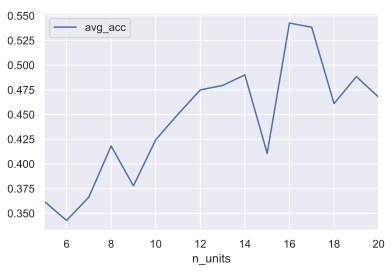

In [74]:
model_selection_results = pd.DataFrame(results)
model_selection_results.plot(x='n_units', y='avg_acc');

Through the plot above, it can be seen the rise in accuracy when increasing the number of units for hidden layer. Thus let's keep testing MLPs with more hidden units.

In [75]:
%timeit
for units in range(21, 31):
    scores = []
    for subtrain_index, valid_index in skf.split(X_train, y_train):   
        # split the original dataset into training and test sets
        X_subtrain, X_valid = X_train[subtrain_index], X_train[valid_index]
        y_subtrain, y_valid = y_train[subtrain_index], y_train[valid_index]
        y_subtrain_encoded = to_categorical(y_subtrain)
        y_valid_encoded = to_categorical(y_valid)
    
        mlp = mlp_classifier(n_features, units, 'adam', 'relu')
        # Train the model and make predictions on the validation set
        mlp.fit(X_subtrain,
                y_subtrain_encoded,
                epochs=20,
                verbose=0,
                callbacks=[early_stopping_monitor],
                validation_data=(X_valid, y_valid_encoded),
                initial_epoch=1)
        # Make prediction on validation set
        y_pred_prob = mlp.predict(X_valid)
        y_pred = np.argmax(y_pred_prob, axis=1)
        scores.append(accuracy_score(y_valid, y_pred))
    average_acc = np.mean(scores)
    results.append({'n_units': units, 'avg_acc': average_acc})
    
    print('# units: {:2d}  Average accuracy: {:.2%}'.format(units, average_acc))
print('Total number of samples used for training: {}'.format(X_subtrain.shape[0]))
print('Total number of samples used for model performance evaluating: {}'.format(X_valid.shape[0]))

# units: 21  Average accuracy: 58.12%
# units: 22  Average accuracy: 49.85%
# units: 23  Average accuracy: 49.49%
# units: 24  Average accuracy: 54.39%
# units: 25  Average accuracy: 50.89%
# units: 26  Average accuracy: 50.98%
# units: 27  Average accuracy: 57.80%
# units: 28  Average accuracy: 56.51%
# units: 29  Average accuracy: 54.49%
# units: 30  Average accuracy: 55.22%
Total number of samples used for training: 132
Total number of samples used for model performance evaluating: 12


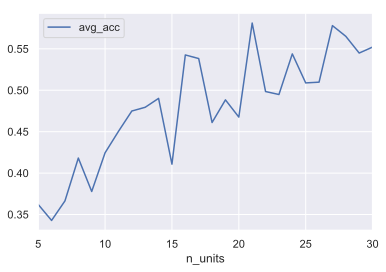

In [76]:
model_selection_results = pd.DataFrame(results)
ax = model_selection_results.plot(x='n_units', y='avg_acc');

By adding more units to the hidden layer, the accuracy continues to steadily increse. With that results, moving on to tune the number of hidden units by testing bigger values for that.

In [77]:
%timeit
for units in range(31, 41):
    scores = []
    for subtrain_index, valid_index in skf.split(X_train, y_train):   
        # split the original dataset into training and test sets
        X_subtrain, X_valid = X_train[subtrain_index], X_train[valid_index]
        y_subtrain, y_valid = y_train[subtrain_index], y_train[valid_index]
        y_subtrain_encoded = to_categorical(y_subtrain)
        y_valid_encoded = to_categorical(y_valid)
    
        mlp = mlp_classifier(n_features, units, 'adam', 'relu')
        # Train the model and make predictions on the validation set
        mlp.fit(X_subtrain,
                y_subtrain_encoded,
                epochs=20,
                verbose=0,
                callbacks=[early_stopping_monitor],
                validation_data=(X_valid, y_valid_encoded),
                initial_epoch=1)
        # Make prediction on validation set
        y_pred_prob = mlp.predict(X_valid)
        y_pred = np.argmax(y_pred_prob, axis=1)
        scores.append(accuracy_score(y_valid, y_pred))
    average_acc = np.mean(scores)
    results.append({'n_units': units, 'avg_acc': average_acc})
    
    print('# units: {:2d}  Average accuracy: {:.2%}'.format(units, average_acc))
print('Total number of samples used for training: {}'.format(X_subtrain.shape[0]))
print('Total number of samples used for model performance evaluating: {}'.format(X_valid.shape[0]))

# units: 31  Average accuracy: 60.77%
# units: 32  Average accuracy: 59.04%
# units: 33  Average accuracy: 58.26%
# units: 34  Average accuracy: 57.09%
# units: 35  Average accuracy: 58.17%
# units: 36  Average accuracy: 56.11%
# units: 37  Average accuracy: 59.24%
# units: 38  Average accuracy: 59.72%
# units: 39  Average accuracy: 56.46%
# units: 40  Average accuracy: 60.16%
Total number of samples used for training: 132
Total number of samples used for model performance evaluating: 12


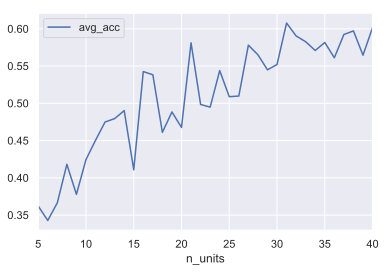

In [78]:
model_selection_results = pd.DataFrame(results)
ax = model_selection_results.plot(x='n_units', y='avg_acc');

Here the accuracy has started to fluctuate widely by adding more hidden units up to 40 and reached the pick **60.77%** which corresponds to the hidden units values of **31**. Then it has started dropping and then going up not exceeding the value of 60%. Hence we assume that further icreasing of number of hidden units will not give more reasonable and successfull results.

Based on gained outcome of playing with number of hidden units, now we can find the optimal value for number of hidden units.

In [79]:
best_score = np.max(model_selection_results['avg_acc'])
n_units_best = model_selection_results[model_selection_results['avg_acc'] == best_score]['n_units'].values
n_units_best = n_units_best[0]
print('The optimal number of units for a hidden layer: {}'.format(n_units_best))
print('Accuracy: {:.2%}'.format(best_score))

The optimal number of units for a hidden layer: 31
Accuracy: 60.77%


Use the complete training set with the optimal number of hidden units for model fitting and evaluate the preformance of this model on the test set

In [80]:
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

final_mlp = mlp_classifier(n_features, n_units_best, 'adam', 'relu')
final_mlp.fit(X_train,
              y_train_encoded,
              epochs=20,
              verbose=0,
              callbacks=[early_stopping_monitor],
              validation_data=(X_test, y_test_encoded),
              initial_epoch=1)
y_pred_prob = mlp.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

print('Accuracy of MLP with one hidden layer composing of {} units: {:.2%}'.format(n_units_best, accuracy_score(y_test, y_pred)))

Accuracy of MLP with one hidden layer composing of 31 units: 75.00%


While evaluating the model performance on the test set, the performance has jumped up by 15% more which is really surprising.

Finally, let's take a look at the confusion matrix and compare results with previous ones

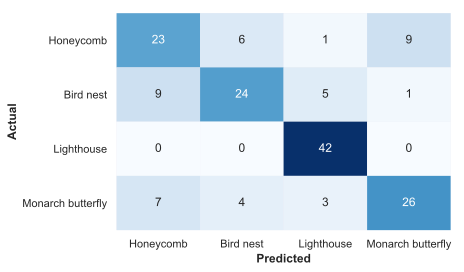

In [81]:
y_pred_prob_train = mlp.predict(X_train)
y_pred_train = np.argmax(y_pred_prob_train, axis=1)

cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred)
cm_test += cm_train
plot_confusion_matrix(cm_test)

We have got quite interesting and controversial results comparing with `Logistic Regression`.

* Although for all the classes the majority of samples has been classified correcly, there is a drop in their numbers except for `lighthouse` class. MLP has managed to fully recognize `lighthouse` class which is really remarkable achievement. However. as we said, the number of correcly classified samples for `honeycomb` class has dropped by 5 points, for `birdnest` class by 3 points and for `monarch butterfly` class by 9 points respectively. The relatively high accuracy at least comparing with `KNN` results can be explained by mostly contribution of 100% recognized major class.

## Results and discussions

We have trained three different classifiers which have following accuracies
1. Regularized Logistic Regression: **79.38%**
2. Multi-layer perceptron with one hidden layer: **75.00%**
3. KNN: **65.00%**


`Logistic Regression` model has perfomed the best. Its accuracy is very close to 80% which is not that bad but still not impressive.
All three classifiers did good job to recognize `Lighthouse` samples mostly. This can explained by the majority of samples representing this class. Even the difference by 2-3 samples in class distribution drastically affects the chances of each class to be recognized. Since `Lighthouse` class is mostly represented in the data, its samples are more likely to be classified correctly and at the same time misclassified samples tend to be more often assigned to dominating class rathen than to other classes. Thus correctly classified samples of dominating class contribute to the total accuracy the most.

Also there is one more common tendency for all the classifiers. They are all failing to recognize `Honeycomb` and `Monarch butterfly` classes since their samples look alike in terms of features.

Relatively low accuracy of `KNN` model can be related to widely spread out data and a lot of outliers. As we saw through PCA and SOM illustrations of feature relationships the data are quite messy and not clearly separable. Since kNN classification approach is based on smaller distance between similar instances, it's not reliable to focus only on several neighboring samples.

The same can be said about `Logistic Regression` results. Looking at visualization of our data in 3D space of three first PCs, it seems quite challenging to separate four classes with lines. There are no solid boundaries between classes. Hence that case is probably not linearly separable.

### Possible improvements
* The first thing we can do to improve models performances is to **collect more data**. Now we have only **160 samples**, that number of samples for multi-class problem is not adequate to build a robust predictor.
* The ideal situation when it comes to multi-class tasks is a uniform class distribution to ensure that all the classes are equally recognizable and contribute equally to the data. Although in practice this situation happens quite rarel. In that case, the solution would be **put some weights to classes** in order to shift a classifier's focus to minor class representatives. In this way we penalize the cassifier less for incorrectly classifed  major class samples and put the emphasise on correcly classifiying minor class instances.
* For `Logistic Regression` it might be beneficial to add some polinomial features to extend its possibilities to build more complex descion boundaries. However, it leads to a huge rise in number of featurs, especially if their number is large initially. Additionally, it involves a lot of heavy computations.
* One way to improve the performance of `kNN` classifier is to choose the optimal **distance metric** and **weighting function** for neighbors
* For `MLP` classifier, there are various ways to improve its performance. Here are some of possible ones:
    * add another one hidden layer and optimize the number of units in order to build more conves decision regions
    * try different activation functions like 'relu', 'sigmod', 'tangh' within hidden layers
    * add a dropout layer to escape overfitting
    * optimize the number of epoches for training
    * try different optimizers and tune their parameters

#### Packages versions info

In [99]:
import sys
import matplotlib
import skimage
import sklearn
import keras


for package, version in (('python', sys.version),
                         ('numpy', np.__version__),
                         ('pandas', pd.__version__),
                         ('matplotlib', matplotlib.__version__),
                         ('seaborn', sns.__version__),
                         ('skimage', skimage.__version__),
                         ('sklearn', sklearn.__version__),
                         ('keras', keras.__version__)):
    print('{:12s} {}'.format(package, version))

python       3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]
numpy        1.16.3
pandas       0.24.2
matplotlib   3.0.3
seaborn      0.9.0
skimage      0.15.0
sklearn      0.20.3
keras        2.2.4
